## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
!pip install swifter

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

import swifter

In [3]:
import warnings
warnings.filterwarnings("ignore")
# row/column display limit
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
# Import Textblob for extracting noun phrases
!pip install textblob
from textblob import TextBlob

In [5]:
# Installing wordcloud
!pip install wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [6]:
# Import pickle to save and load the model
import pickle

In [7]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sarav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sarav\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [8]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json','r')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [9]:
# Inspect the dataframe to understand the given data.

df.shape

(78313, 22)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [11]:
#print the column names

pprint(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [12]:
#print top rows of the dataframe

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [13]:
#Assign new column names

df.columns = [x.replace('_','').replace('source.','') for x in df.columns]

In [14]:
#Complaintswhathappened as the target columns and renaming it to complaints

df.rename(columns={'complaintwhathappened':'complaints'}, inplace=True)

df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zipcode', 'complaintid',
       'issue', 'datereceived', 'state', 'consumerdisputed', 'product',
       'companyresponse', 'company', 'submittedvia', 'datesenttocompany',
       'companypublicresponse', 'subproduct', 'timely', 'complaints',
       'subissue', 'consumerconsentprovided'],
      dtype='object')

In [15]:
#checking the dataset for null values

df.isnull().sum()

index                          0
type                           0
id                             0
score                          0
tags                       67413
zipcode                     6757
complaintid                    0
issue                          0
datereceived                   0
state                       1991
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      78309
subproduct                 10571
timely                         0
complaints                     0
subissue                   46297
consumerconsentprovided     1008
dtype: int64

In [16]:
#Assign nan in place of blanks in the complaints column

(df.complaints == '').sum()

57241

In [17]:
df.complaints.replace('',np.nan, inplace=True)

In [18]:
#Remove all rows where complaints column is nan

df.dropna(subset=['complaints'], inplace=True)

In [19]:
df.reset_index(inplace=True)

In [20]:
#checking the available rows

df.shape

(21072, 23)

In [21]:
21072/78313*100

26.90741000855541

- We lost almost 64% of data but we still have 27% for further analysis

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [22]:
#Checking first few complaints

df.complaints[0]

'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.'

In [23]:
df.complaints[1]

'I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.'

In [24]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean_text(sent):
    sent = sent.lower() # Text to lowercase
    sent = re.sub(r'\[|\]',"",sent) #Remove text in square brackets
    sent = re.sub(r'[^\w\s]',"", sent) #Remove puntuations
    sent = re.sub(r'\w*\d\w*',"",sent) #Remove words containing numbers
    return " ".join(sent.split()) #Removing other empty spaces

In [25]:
df_clean = pd.DataFrame(df['complaints'].swifter.apply(clean_text))

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [26]:
df_clean.complaints.loc[0]

'good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help'

In [27]:
#Write your function to Lemmatize the texts

def lemmatize_text(text):
    sent=[]
    doc = nlp(text)
    
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [28]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean['complaints_lemmatized'] = df_clean['complaints'].swifter.apply(lemmatize_text)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [29]:
df_clean.head()

,complaints,complaints_lemmatized
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not state why I ask for more informatio

In [30]:
#Write your function to extract the POS tags 

def get_POS_tags(text):
  # write your code here
    sent = []
    blob = TextBlob(text)
    sent = [word for (word, tag) in blob.tags if tag=='NN']
    return " ".join(sent)

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean['complaints'].swifter.apply(get_POS_tags)


Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [31]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaints,complaints_lemmatized,complaint_POS_removed
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember debt verification statement i bank debt mail month debt i right information consumer chase account advance help
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,i card agent upgrade date agent information order account date xxxxxxxx consent xxxx recording agent
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent credit identity applicant
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via th

In [32]:
df_clean.shape

(21072, 3)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




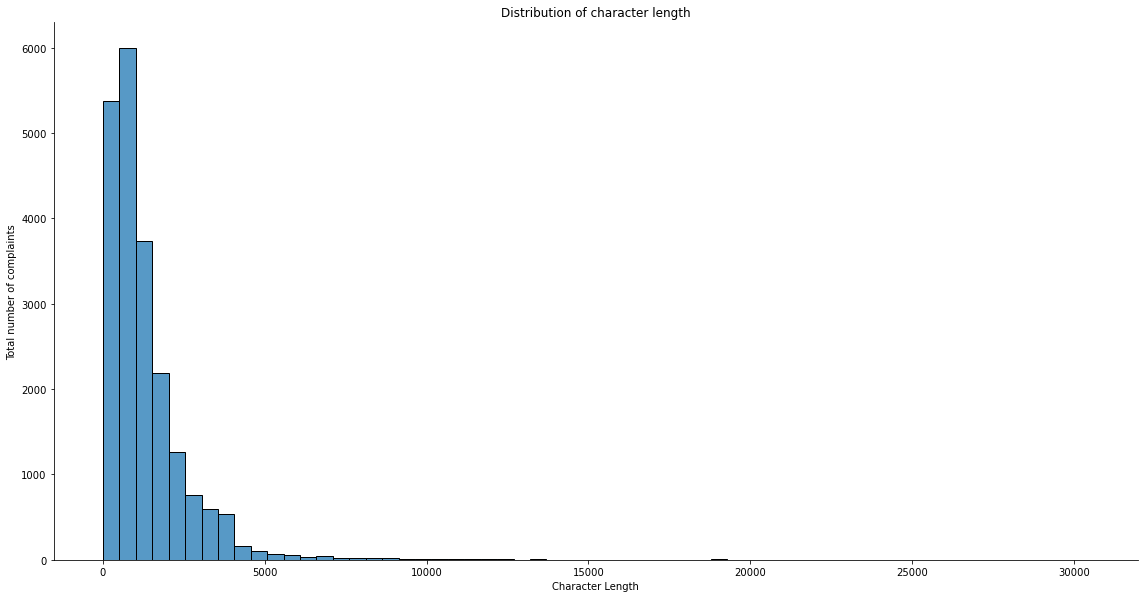

In [33]:
# Write your code here to visualise the data according to the 'Complaint' character length

char_len = [len(each_sent) for each_sent in df_clean['complaints']]

sns.displot(char_len, kind='hist', bins=60, height=8, aspect=2)
plt.xlabel('Character Length')
plt.ylabel('Total number of complaints')
plt.title('Distribution of character length')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

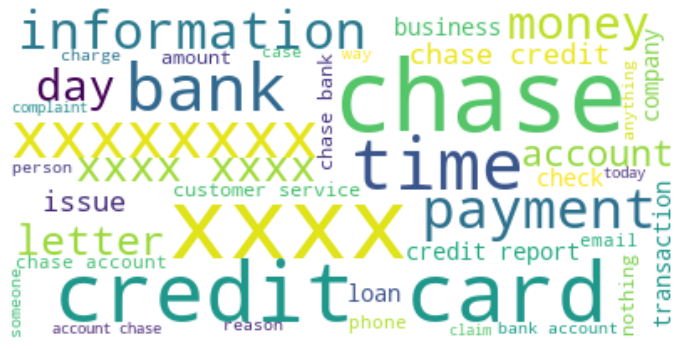

In [34]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=40, background_color='white', random_state=100,
                     stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [35]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [36]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_ngrams(text, n=None, ngram=(1,1)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
    bagofwords = vec.transform(text)
    sum_words = bagofwords.sum(axis=0)
    words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
    words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
    return words_frequency[:n]

In [37]:
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,chase,51792
1,account,41080
2,xxxx,39876
3,credit,32677
4,bank,26650
5,card,26054
6,payment,13967
7,xxxxxxxx,12703
8,time,11972
9,money,11946


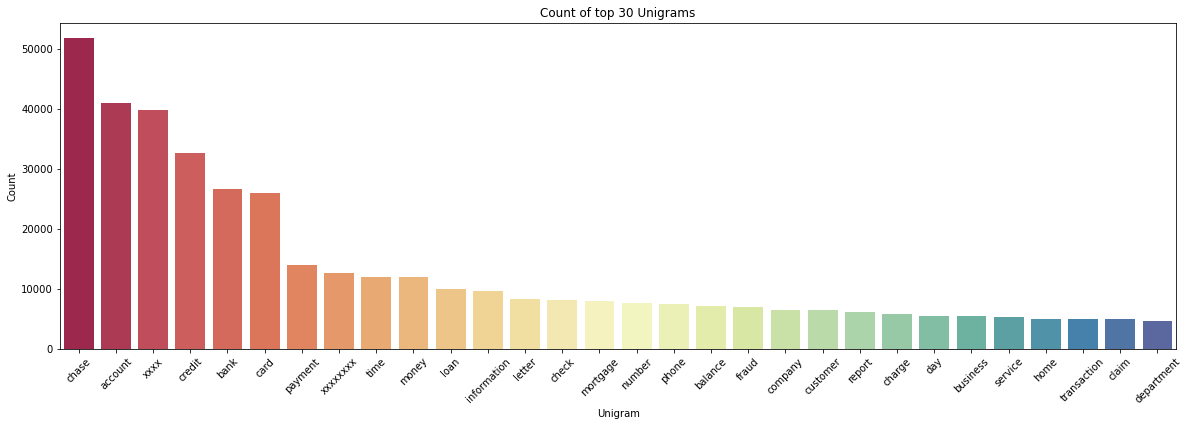

In [38]:
#Plotting top 30 unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'], palette='Spectral')
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [39]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,chase,51792
1,account,41080
2,xxxx,39876
3,credit,32677
4,bank,26650
5,card,26054
6,payment,13967
7,xxxxxxxx,12703
8,time,11972
9,money,11946


In [40]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram','count'])
df_bigram

,bigram,count
0,credit card,11035
1,xxxx xxxx,4781
2,chase credit,3509
3,credit report,3274
4,chase account,3140
5,chase bank,3035
6,customer service,3026
7,account chase,2955
8,bank account,2841
9,account account,2777


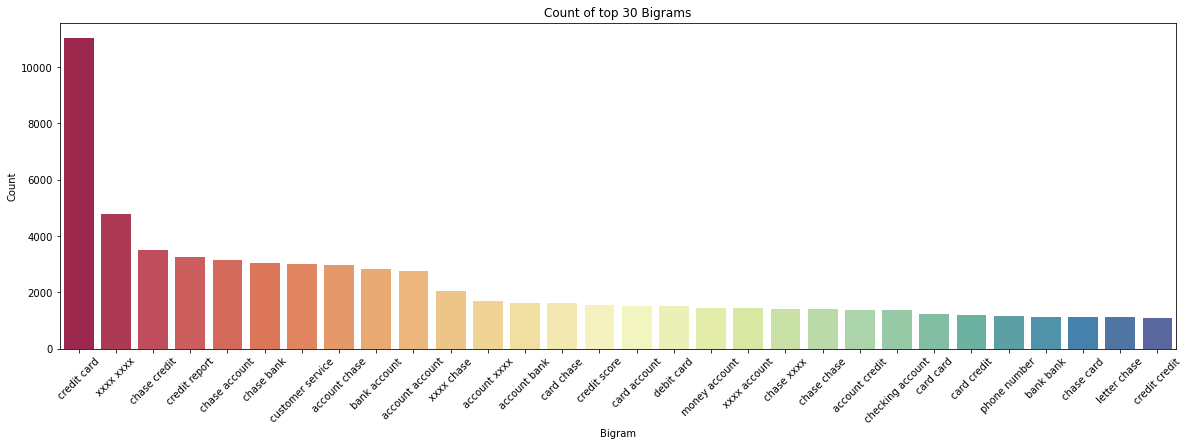

In [41]:
#Plotting top 30 bigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram['bigram'], y=df_bigram['count'], palette='Spectral')
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 30 Bigrams")
plt.show()

In [42]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,11035
1,xxxx xxxx,4781
2,chase credit,3509
3,credit report,3274
4,chase account,3140
5,chase bank,3035
6,customer service,3026
7,account chase,2955
8,bank account,2841
9,account account,2777


In [43]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram','count'])
df_trigram

,trigram,count
0,chase credit card,1944
1,credit card account,831
2,credit card company,819
3,credit card chase,734
4,credit card credit,615
5,xxxx xxxx xxxx,615
6,card credit card,423
7,xxxx credit card,402
8,credit card xxxx,384
9,account chase account,382


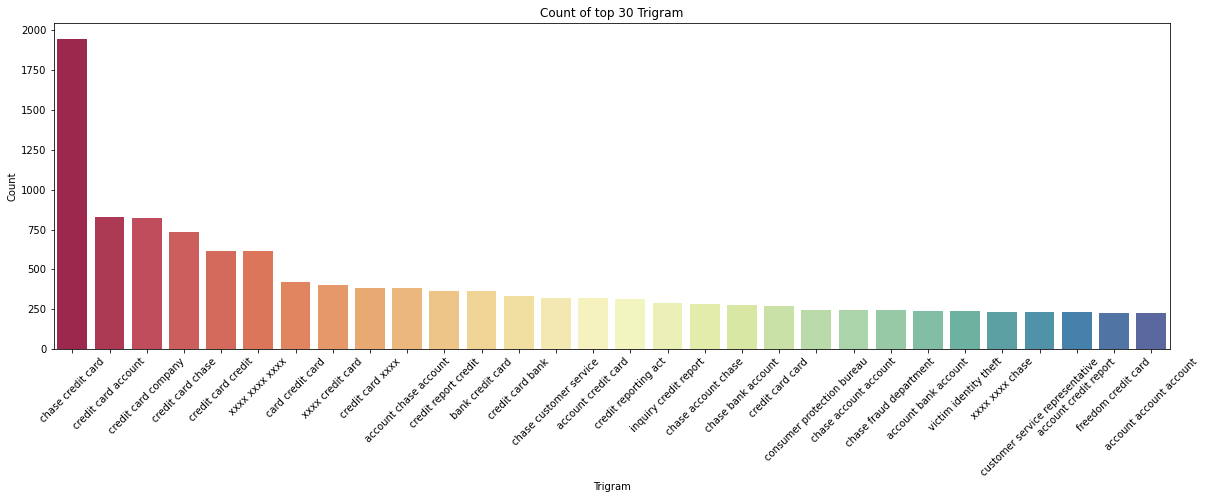

In [44]:
#Plotting top 30 trigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_trigram['trigram'], y=df_trigram['count'], palette='Spectral')
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Count of top 30 Trigram")
plt.show()

In [45]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,1944
1,credit card account,831
2,credit card company,819
3,credit card chase,734
4,credit card credit,615
5,xxxx xxxx xxxx,615
6,card credit card,423
7,xxxx credit card,402
8,credit card xxxx,384
9,account chase account,382


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [46]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [47]:
#All masked texts has been removed
df_clean.head()

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember debt verification statement i bank debt mail month debt i right information consumer chase account advance help,morning name stop bank cardmember debt verification statement i bank debt mail month debt i right information consumer chase account advance help
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,i card agent upgrade date agent information order account date xxxxxxxx consent xxxx recording agent,i card agent upgrade date agent information order account date consent recording agent
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent credit identity applicant,card application identity consent credit identity applicant
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even t

In [48]:
df_clean.shape

(21072, 4)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [49]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(min_df=2, max_df=0.90, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [50]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

In [51]:
dtm

<21072x6706 sparse matrix of type '<class 'numpy.float64'>'
	with 501236 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [52]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [53]:
#Load your nmf_model with the n_components i.e 5

#write the value you want to test out
num_topics = 5

#keep the random_state =40

#write your code here
nmf_model = NMF(n_components=num_topics, random_state=40)

In [54]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

6706

In [55]:
# Topic-term matrix
H = nmf_model.components_
print(H)

[[0.00000000e+00 0.00000000e+00 3.33918840e-04 ... 4.64136619e-05
  0.00000000e+00 1.34775712e-03]
 [1.98578972e-04 1.27566272e-03 0.00000000e+00 ... 0.00000000e+00
  2.48975926e-04 7.38622138e-04]
 [4.58865335e-04 0.00000000e+00 1.27053569e-04 ... 2.73987088e-04
  1.27152422e-03 2.88439876e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.43531905e-04
  8.72818484e-04 0.00000000e+00]
 [0.00000000e+00 5.77827343e-04 1.06630872e-04 ... 0.00000000e+00
  0.00000000e+00 8.50981134e-04]]


In [56]:
#Print the Top15 words for each of the topics

words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,money,check,chase,branch,deposit,number,fraud,business,checking,transaction,claim,information,day
Topic 2,card,chase,credit,charge,fraud,dispute,company,merchant,fee,purchase,balance,time,service,phone,letter
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,house,letter,rate,time,sale,bank,information,process
Topic 4,credit,report,inquiry,score,debt,reporting,account,information,bureaus,limit,identity,theft,company,history,bureau
Topic 5,payment,balance,month,statement,fee,date,auto,time,chase,account,day,error,car,pay,history


In [57]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)

In [58]:
#Assign the best topic to each of the cmplaints in Topic Column

#write your code to assign topics to each rows.
df_clean['Topic'] = topic_results.argmax(axis=1)

In [59]:
df_clean.head()

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember debt verification statement i bank debt mail month debt i right information consumer chase account advance help,morning name stop bank cardmember debt verification statement i bank debt mail month debt i right information consumer chase account advance help,0
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,i card agent upgrade date agent information order account date xxxxxxxx consent xxxx recording agent,i card agent upgrade date agent information order account date consent recording agent,1
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent credit identity applicant,card application identity consent credit identity applicant,3
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit r

In [60]:
#Print the first 5 Complaint for each of the Topics
df_clean_top5=df_clean.groupby('Topic').head(5)
df_clean_top5.sort_values('Topic')

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember debt verification statement i bank debt mail month debt i right information consumer chase account advance help,morning name stop bank cardmember debt verification statement i bank debt mail month debt i right information consumer chase account advance help,0
10,mishandling of this account by chase auto and xxxx,mishandle of this account by chase auto and xxxx,mishandling account auto xxxx,mishandling account auto,0
6,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I go into a branch after be advise by a customer service representative that my account would actually be close I go into the branch to see how I can remove the fund that be in there currently in as well as if my direct deposit 

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [61]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services", 1:"Theft/Dispute Reporting", 2:"Mortgage/Loan",
               3:"Credit card or prepaid card",4:"Others"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [62]:
df_clean.head()

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember debt verification statement i bank debt mail month debt i right information consumer chase account advance help,morning name stop bank cardmember debt verification statement i bank debt mail month debt i right information consumer chase account advance help,Bank Account services
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,i card agent upgrade date agent information order account date xxxxxxxx consent xxxx recording agent,i card agent upgrade date agent information order account date consent recording agent,Theft/Dispute Reporting
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent credit identity applicant,card application identity consent credit identity applicant,Credit card or prepaid card
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit rep

In [63]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [64]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,"Theft/Dispute Reporting":1,"Mortgage/Loan":2,
               "Credit card or prepaid card":3,"Others":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [65]:
df_clean.head()

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember debt verification statement i bank debt mail month debt i right information consumer chase account advance help,morning name stop bank cardmember debt verification statement i bank debt mail month debt i right information consumer chase account advance help,0
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,i card agent upgrade date agent information order account date xxxxxxxx consent xxxx recording agent,i card agent upgrade date agent information order account date consent recording agent,1
2,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent credit identity applicant,card application identity consent credit identity applicant,3
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit r

In [66]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaints','Topic']]

In [67]:
training_data.shape

(21072, 2)

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [68]:
#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaints'])

# Save word vector
pickle.dump(vect.vocabulary_, open("count_vector.pk1", "wb"))

In [69]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

# Save tfidf
pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [70]:
# Write your code here to build any 3 models and evaluate them using the required metrics

In [71]:
# Importing required libraries
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# Importing Train, Test Split
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [72]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [73]:
# Function to evaluate the models

def model_eval(y_test, y_pred, model_name):
    
    #Classification report
    print(f'''Classification Report for {model_name}:
          
          {classification_report(y_test, y_pred, target_names=['Bank Account services','Theft/Dispute Reporting', 'Mortgage/Loan','Credit card or prepaid card','Others'])}''')
    
    return

### 1. Logisitic Regression

In [74]:
#Logistic Regression with default parameters

model_name = 'Logistic Regression'
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [75]:
#Calculating f1 score

f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
f1_lr

0.924670234558758

In [76]:
#Creating model with tuned hyperparameter

lr_tuned = LogisticRegression(C=1, penalty='l1', solver='saga')
lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [77]:
#Calculating f1 score for the tuned model

f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average='weighted')
f1_lr_tuned

0.9515684244372933

In [78]:
#Evaluate the tuned model

model_eval(y_test, y_pred_lr_tuned, model_name)

Classification Report for Logistic Regression:
          
                                       precision    recall  f1-score   support

      Bank Account services       0.95      0.97      0.96      1549
    Theft/Dispute Reporting       0.94      0.96      0.95      1472
              Mortgage/Loan       0.97      0.94      0.96       915
Credit card or prepaid card       0.95      0.94      0.94       754
                     Others       0.95      0.94      0.94       578

                   accuracy                           0.95      5268
                  macro avg       0.95      0.95      0.95      5268
               weighted avg       0.95      0.95      0.95      5268



In [79]:
#Creating a dataframe to store f1-score of all the models

f1_summary = pd.DataFrame([{'Model': 'Logistic Regression','f1-score': round(f1_lr, 2), 
                            'f1-score after tune': round(f1_lr_tuned, 2)}])
f1_summary

,Model,f1-score,f1-score after tune
0,Logistic Regression,0.92,0.95


### 2. Decision Tree Classifier

In [80]:
#Decision Tree with default hyperparameters

model_name = 'Decision Tree'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [81]:
#Calculating f1 score

f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
f1_dt

0.8264653590101934

In [82]:
#Decision Tree with tuned hyperparameters

dt_tuned = DecisionTreeClassifier(criterion='gini', max_depth=25, min_samples_leaf=15)
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [83]:
#Calculating f1 score for the tuned model

f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned, average='weighted')
f1_dt_tuned

0.8397971728240278

In [84]:
#Evaluate the tuned Decision Tree model

model_eval(y_test, y_pred_dt_tuned, model_name)

Classification Report for Decision Tree:
          
                                       precision    recall  f1-score   support

      Bank Account services       0.84      0.89      0.86      1549
    Theft/Dispute Reporting       0.84      0.84      0.84      1472
              Mortgage/Loan       0.85      0.83      0.84       915
Credit card or prepaid card       0.83      0.79      0.81       754
                     Others       0.83      0.78      0.81       578

                   accuracy                           0.84      5268
                  macro avg       0.84      0.83      0.83      5268
               weighted avg       0.84      0.84      0.84      5268



In [85]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Decision Tree', round(f1_dt, 2), round(f1_dt_tuned, 2)]
f1_summary

,Model,f1-score,f1-score after tune
0,Logistic Regression,0.92,0.95
1,Decision Tree,0.83,0.84


### 3. Random Forest

In [86]:
#Random forest with default hyperparaemters

model_name = 'Random Forest'
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [87]:
#Calculating f1 score

f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
f1_rf

0.7790694307971006

In [88]:
#Random forest with tuned hyperparameters

rf_tuned = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, 
                                  min_samples_leaf=2, max_features='sqrt')
rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = rf_tuned.predict(X_test)

In [89]:
#Calculating f1 score after tunning

f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average='weighted')
f1_rf_tuned

0.7200871333858071

In [90]:
#Evaluate the tuned Random Forest model

model_eval(y_test, y_pred_rf_tuned, model_name)

Classification Report for Random Forest:
          
                                       precision    recall  f1-score   support

      Bank Account services       0.72      0.92      0.81      1549
    Theft/Dispute Reporting       0.68      0.88      0.77      1472
              Mortgage/Loan       0.87      0.82      0.84       915
Credit card or prepaid card       0.88      0.48      0.62       754
                     Others       0.97      0.17      0.29       578

                   accuracy                           0.75      5268
                  macro avg       0.82      0.66      0.67      5268
               weighted avg       0.79      0.75      0.72      5268



In [91]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Random Forest', round(f1_rf, 2), round(f1_rf_tuned, 2)]
f1_summary

,Model,f1-score,f1-score after tune
0,Logistic Regression,0.92,0.95
1,Decision Tree,0.83,0.84
2,Random Forest,0.78,0.72


### 4. Naive Bayes

In [92]:
# Import required library
from sklearn.naive_bayes import MultinomialNB

#Multinomial Naive Bayes with default parameters

model_name = 'Naive Bayes'
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [93]:
#Calculating f1 score

f1_nb = f1_score(y_test, y_pred_nb, average='weighted')
f1_nb

0.5903609249448846

In [94]:
# Naive Bayes with tuned hyperparameters                            
nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)
nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = nb_tuned.predict(X_test)

In [95]:
#Calculating f1 score after tunning

f1_nb_tuned = f1_score(y_test, y_pred_nb_tuned, average='weighted')
f1_nb_tuned

0.7633343628356012

In [96]:
# Evaluate the Naive Bayes classifier

model_eval(y_test, y_pred_nb_tuned, model_name)

Classification Report for Naive Bayes:
          
                                       precision    recall  f1-score   support

      Bank Account services       0.78      0.83      0.80      1549
    Theft/Dispute Reporting       0.78      0.75      0.77      1472
              Mortgage/Loan       0.84      0.85      0.84       915
Credit card or prepaid card       0.70      0.71      0.71       754
                     Others       0.65      0.57      0.61       578

                   accuracy                           0.76      5268
                  macro avg       0.75      0.74      0.74      5268
               weighted avg       0.76      0.76      0.76      5268



In [97]:
# Update the summary table

f1_summary.loc[len(f1_summary.index)] = ['Naive Bayes', round(f1_nb, 2), round(f1_nb_tuned, 2)]
f1_summary

,Model,f1-score,f1-score after tune
0,Logistic Regression,0.92,0.95
1,Decision Tree,0.83,0.84
2,Random Forest,0.78,0.72
3,Naive Bayes,0.59,0.76


#### Logistic Regression with tuned hyperparameters showing high f1-score 0.95 compared to other models.

In [98]:
# Save Logistic Regression model as pickle file in device

pickle.dump(lr_tuned, open("logreg_model.pkl", "wb"))

### Predicting topics via Logistic Regression on custom text

In [99]:
def topic_predicter(text):
    
    target_names = ['Bank Account services','Theft/Dispute Reporting', 'Mortgage/Loan','Credit card or prepaid card','Others']

    load_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pk1", "rb")))
    load_tfidf = pickle.load(open("tfidf.pk1","rb"))
    load_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_count = load_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count)
    prediction = load_model.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [100]:
# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "unwanted service activated and money deducted automatically ",
                                  "How can I know my CIBIL score?",
                                  "How do I foreclose my personal loan"]})
df_custom

,complaints
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs"
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.
2,I want to open a salary account at your downtown branch. Please provide me the procedure.
3,unwanted service activated and money deducted automatically
4,How can I know my CIBIL score?
5,How do I foreclose my personal loan


In [101]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_custom['predicted topic'] = df_custom['complaints'].apply(lambda x: topic_predicter([x]))
df_custom

,complaints,predicted topic
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs",Mortgage/Loan
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.,Theft/Dispute Reporting
2,I want to open a salary account at your downtown branch. Please provide me the procedure.,Bank Account services
3,unwanted service activated and money deducted automatically,Bank Account services
4,How can I know my CIBIL score?,Credit card or prepaid card
5,How do I foreclose my personal loan,Mortgage/Loan
